# DistilBert

### Import necessary packages

In [1]:
import numpy as np
import mlflow
import logging 
import torch 
import config 
import os 
from mlflow.sklearn import save_model
from transformers import AutoModelForSequenceClassification, AutoConfig

# import mlflow.pytorch
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # This tells Hugging Face: “Don’t use parallel tokenization — avoid possible deadlocks.”

/Users/maren/Library/CloudStorage/OneDrive-Persönlich/Dokumente/neue_fische/Capstone Project/Capstone_project/backend/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from basic_functions import(
    get_encode_tokenize_data,
    createTrainer,
    get_eval_metrics,
    get_error_analysis,
    print_error_df
)

### Setup

In [3]:
MODEL_NAME = "distilbert-base-uncased" # pulls the general-purpose DistilBERT model
TRACKING_URI = open("../.mlflow_uri").read().strip()
EXPERIMENT_NAME = config.EXPERIMENT_NAME

logging.basicConfig(format="%(asctime)s: %(message)s") # Configure logging format to show timestamp before every message

logger = logging.getLogger()
logger.setLevel(logging.INFO) # Only show logs that are INFO or more important (e.g., WARNING, ERROR) — but ignore DEBUG.

In [4]:
# DATA_PATH = "../data/data_small.csv"
DATA_PATH = "../data/data_multiclass_with_none_large.csv" # uncomment this when checking that everything is just running properly. 
MODEL_PATH = "distilbert-base-uncased"
MODEL_TRAINING_PATH ="distilbert-base-uncased"
OUTPUT_DIR = "../models/distilbert_multiclass_with_none_large/trainer_output"
SAVE_PATH = "../models/distilbert_multiclass_with_none_large/pytorch_model"

### Get data

In [5]:
# use "binary" for binary classification and "multiclass" for multiclass classification
train_dataset, test_dataset, encoded_train_dataset, encoded_test_dataset, le = get_encode_tokenize_data("multiclass", DATA_PATH, MODEL_PATH)

2025-04-16 11:56:16,824: Loading data...
2025-04-16 11:56:16,837: Train test split, test-size 0.3
2025-04-16 11:56:16,841: Create encoded dataframes
2025-04-16 11:56:16,842: Encode the label column
2025-04-16 11:56:16,843: Tokenize
2025-04-16 11:56:16,843: create tokenizer & load model
2025-04-16 11:56:17,843: create tokenizer & load model
2025-04-16 11:56:18,300: Create TextDatasets (train & test)


In [6]:
y_train = encoded_train_dataset['logical_fallacies']

### Model Initialization

In [7]:
learning_rate= 3e-5
weight_decay= 0.01
num_train_epochs= 4
evaluation_strategy= 'epoch'
class_weight=False
dropout= 0.3


params = {
      "learning_rate": learning_rate,
      "weight_decay": weight_decay,
      "num_train_epochs": num_train_epochs,
      "evaluation_strategy": evaluation_strategy,
      "class_weight":class_weight,
      "dropout": dropout,
      "dataset": DATA_PATH
  }


# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)


mlflow.start_run()
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))

mlflow.set_tag("model_name", MODEL_NAME)
mlflow.set_tag("mlflow.runName", "Distilbert Multiclass With None Large")
mlflow.log_params(params)

Active run_id: f62c32bd063c4db68e210026382a5c14


In [8]:
num_classes = len(np.unique(y_train))
num_classes

6

In [9]:
# Load config and set dropout
config = AutoConfig.from_pretrained(MODEL_TRAINING_PATH)
config.num_labels = num_classes # Set number of labels for classification
#config.seq_classif_dropout = 0.5  # DistilBERT's classifier-specific dropout parameter
#config.attention_dropout = 0.3 # Set attention dropout, default is 0.1
config.dropout = dropout # Set dropout, default is 0.1

# Load model with updated config
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_TRAINING_PATH,
    config=config  # Pass modified config
)

# model.gradient_checkpointing_enable() 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
trainer = createTrainer(
    model= model, 
    train_dataset = train_dataset,
    test_dataset = test_dataset,
    output_dir= OUTPUT_DIR, 
    y_train=y_train, 
    class_weight=class_weight, 
    epochs=num_train_epochs, 
    learning_rate=learning_rate, 
    weight_decay = weight_decay, 
    train_batch_size=4, 
    eval_batch_size=8 )

2025-04-16 11:56:19,111: defining training arguments
2025-04-16 11:56:19,163: get normal trainer


### Execute Training

In [11]:
torch.mps.empty_cache()  # Clears unused GPU memory

In [12]:
# disable upper limit for memory
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

# Allows up to 100% of available memory
torch.mps.set_per_process_memory_fraction(1.0)  

In [13]:
logger.info('training is running')
trainer.train()

2025-04-16 11:56:19,703: training is running


Epoch,Training Loss,Validation Loss,Accuracy
1,1.005000,0.869052,0.702222
2,0.853400,0.958057,0.714815
3,0.507000,1.101752,0.739259
4,0.408900,1.196377,0.737778


TrainOutput(global_step=3152, training_loss=0.6999119183965746, metrics={'train_runtime': 1158.4211, 'train_samples_per_second': 10.877, 'train_steps_per_second': 2.721, 'total_flos': 1669208286412800.0, 'train_loss': 0.6999119183965746, 'epoch': 4.0})

### Evaluation


In [14]:
def log_metrics(cr, brier, split):
    mlflow.log_metric(f"{split}_brier", brier)

    for key, value in cr.items():
        if (key == "accuracy"):
                # print(f"{split}_{key}", round(value,2))
                mlflow.log_metric(f"{split}_{key}", value)
        else:
            for metric in value:
                mlflow.log_metric(f"{split}_{key}_{metric}", value.get(metric))
                # print(f"{split}_{key}_{metric}", round(value.get(metric),2))

    

2025-04-16 12:15:38,327: predict on test_dataset


2025-04-16 12:16:07,863: get evaluation metrics
2025-04-16 12:16:07,866: classification_report
2025-04-16 12:16:07,875: confusion_matrix
2025-04-16 12:16:07,878: heatmap


                     precision    recall  f1-score   support

         ad_hominem       0.66      0.79      0.71       233
appeal_to_authority       0.74      0.73      0.73       218
  appeal_to_emotion       0.66      0.63      0.65       254
      false_dilemma       0.78      0.76      0.77       232
               none       0.58      0.57      0.58       225
     slippery_slope       0.84      0.76      0.79       188

           accuracy                           0.70      1350
          macro avg       0.71      0.70      0.71      1350
       weighted avg       0.71      0.70      0.70      1350



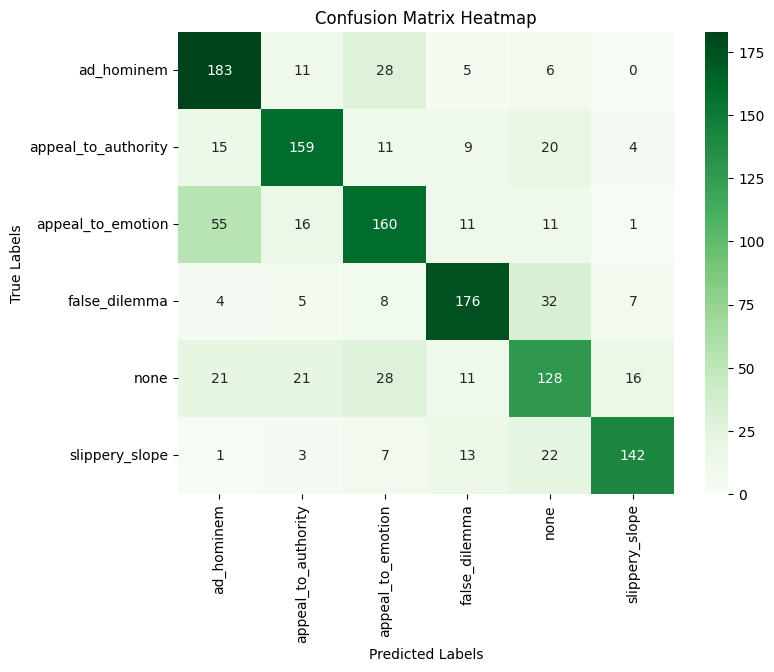

2025-04-16 12:16:08,182: brier score


Multiclass Brier score: 0.42580826722431403


In [15]:
logger.info('predict on test_dataset')
test_output = trainer.predict(test_dataset)

classification_report, brier = get_eval_metrics(test_output, le)
log_metrics(classification_report, brier, "test")


2025-04-16 12:16:08,455: predict on train_dataset


2025-04-16 12:17:19,723: get evaluation metrics
2025-04-16 12:17:19,724: classification_report
2025-04-16 12:17:19,733: confusion_matrix
2025-04-16 12:17:19,738: heatmap


                     precision    recall  f1-score   support

         ad_hominem       0.78      0.81      0.80       545
appeal_to_authority       0.81      0.81      0.81       508
  appeal_to_emotion       0.75      0.77      0.76       592
      false_dilemma       0.83      0.75      0.79       541
               none       0.67      0.70      0.68       525
     slippery_slope       0.88      0.87      0.87       439

           accuracy                           0.78      3150
          macro avg       0.79      0.79      0.79      3150
       weighted avg       0.78      0.78      0.78      3150



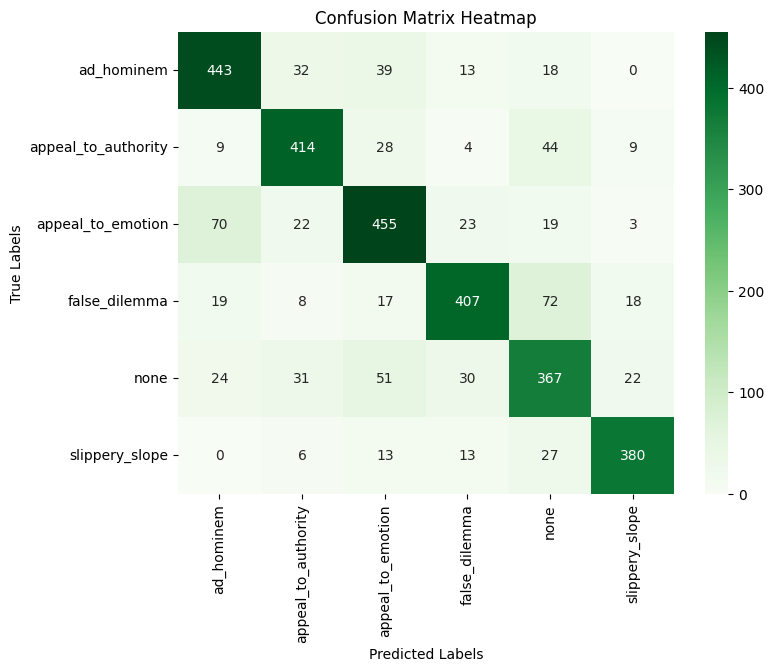

2025-04-16 12:17:19,856: brier score


Multiclass Brier score: 0.31432295519918235


In [16]:
logger.info('predict on train_dataset')
train_output = trainer.predict(train_dataset)

classification_report, brier= get_eval_metrics(train_output, le)
log_metrics(classification_report, brier, "train")


In [17]:
mlflow.end_run()

🏃 View run Distilbert Multiclass With None Large at: http://127.0.0.1:5001/#/experiments/823412171152425451/runs/f62c32bd063c4db68e210026382a5c14
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/823412171152425451


### Save model

In [18]:
#save with pytorch
mlflow.pytorch.save_model(model, path=SAVE_PATH)

### Error Analysis

In [19]:
df_error_test = get_error_analysis(test_output, encoded_test_dataset)

In [20]:
# get text, which is predicted false
print_error_df(df_error_test)

Example 0:
Text: But whether I agree or disagree with some individual or what he may say or how he may say it I don t think there s any way that we can suggest that because people believe in God and go to church that they should not want reflected in those people and those causes they support their own belief in morality and in the high traditions and principles which we ve abandoned so much in this country
True Label: 1, Predicted Label: 3
Example 1:
Text: I think that we must protect the environment the earth is our home and its health is our health I am concerned that we could go too far with protecting the environment this article was a bit worrying in that manner I could envision a situation where the protection of the environment overtakes other concerns We want to protect the oceans and the wildlife inside them but what about the fishermen who depend on their work to survive I can see them and other workers who are displaced by overbearing environmentalism in a state of utter de

In [21]:
# get dataset, with most false predicted values
df_counts = df_error_test[['dataset', 'true_label', 'pred_label']].groupby(['dataset', 'true_label']).value_counts().reset_index()
df_counts.sort_values('count', ascending=False)

,dataset,true_label,pred_label,count
79,9,2,0,25
30,3,5,4,21
41,4,3,4,20
67,8,2,0,13
74,9,0,2,13
...,...,...,...,...
40,4,2,3,1
63,6,4,0,1
62,6,4,1,1
61,6,3,1,1
